## You know the usual Stuff...........Import

In [76]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET
import tensorflow as tf

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from keras.utils import np_utils

from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input

In [78]:
!pip install tensorflow keras numpy pandas matplotlib

^C
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)


![title](para2.png)

![title](neuron.png)

![title](neural.png)

# 1. DATA And PreProcessing

# 2. MODEL And Training

# 3. Testing And Deployment

In [77]:
breed_list = os.listdir("E:/Projects/tensorflow/breed_dog_only/Data/dog/images")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("E:/Projects/tensorflow/breed_dog_only/Data/dog/images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


In [36]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [79]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "E:/Projects/tensorflow/breed_dog_only/Data/dog/images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02085936-Maltese_dog


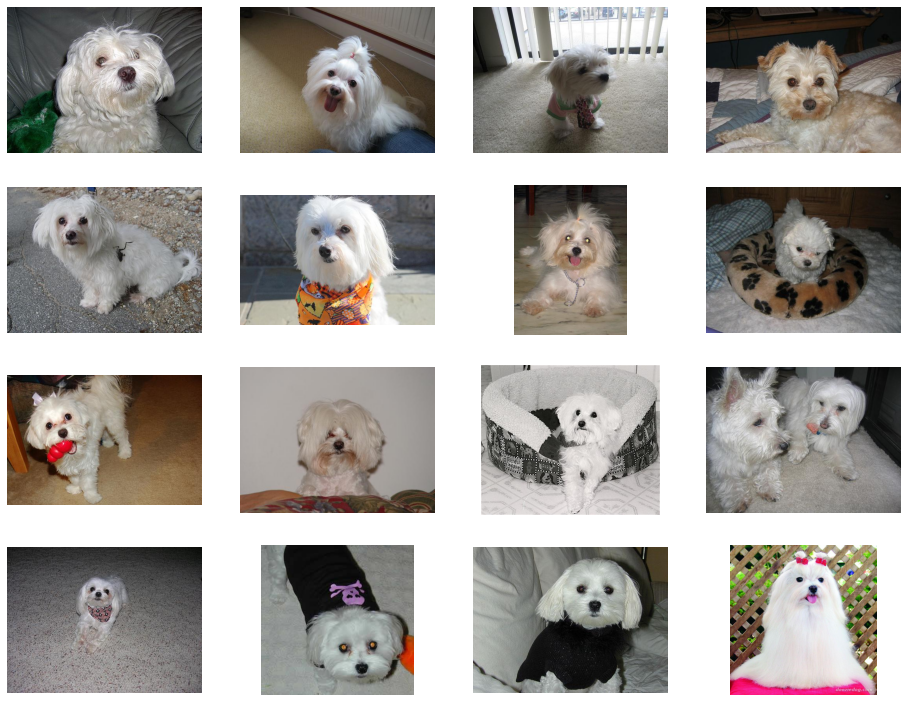

In [83]:
print(breed_list[2])
show_dir_images(breed_list[2], 16)

In [84]:
%%time


# os.mkdir('data')
# for breed in breed_list:
#     os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir('E:/Projects/tensorflow/breed_dog_only/Data/dog/annotations/Annotation/{}'.format(breed)):
        img = Image.open('E:/Projects/tensorflow/breed_dog_only/Data/dog/images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('E:/Projects/tensorflow/breed_dog_only/Data/dog/annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

Created 120 folders to store cropped images of the different breeds.
Wall time: 3min 54s


In [85]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

In [86]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

In [42]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

In [43]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights="imagenet",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

In [87]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [88]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [89]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [90]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=5)

Epoch 1/5
547/547 [==============================] - 133s 236ms/step - loss: 1.1806 - acc: 0.6640 - val_loss: 0.5865 - val_acc: 0.8189loss: 1.1806 - acc: 0.6
Epoch 2/5
547/547 [==============================] - 62s 114ms/step - loss: 1.1918 - acc: 0.6564 - val_loss: 0.5765 - val_acc: 0.8176
Epoch 3/5
547/547 [==============================] - 64s 117ms/step - loss: 1.1868 - acc: 0.6600 - val_loss: 0.6072 - val_acc: 0.8144
Epoch 4/5
547/547 [==============================] - 61s 111ms/step - loss: 1.1642 - acc: 0.6665 - val_loss: 0.5999 - val_acc: 0.8121
Epoch 5/5
547/547 [==============================] - 60s 110ms/step - loss: 1.1765 - acc: 0.6597 - val_loss: 0.6173 - val_acc: 0.8056


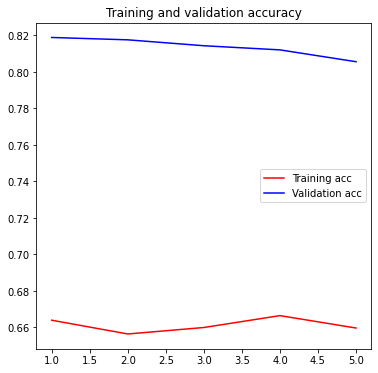

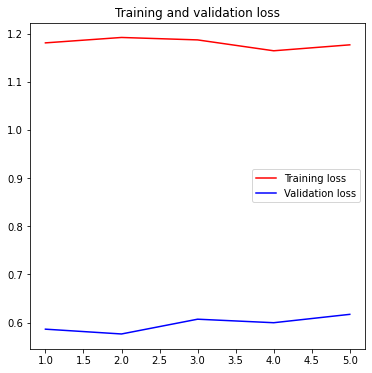

In [91]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [92]:
for layer in model.layers[:]:
    layer.trainable = True

In [93]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint('dog_breed_classifier_model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [94]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=5,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/5
547/547 [==============================] - 63s 116ms/step - loss: 1.1797 - acc: 0.6604 - val_loss: 0.5999 - val_acc: 0.8160

Epoch 00001: val_acc improved from -inf to 0.81600, saving model to dog_breed_classifier_model.h5
Epoch 2/5
547/547 [==============================] - 61s 112ms/step - loss: 1.1606 - acc: 0.6700 - val_loss: 0.6026 - val_acc: 0.8163

Epoch 00002: val_acc improved from 0.81600 to 0.81633, saving model to dog_breed_classifier_model.h5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 3/5
547/547 [==============================] - 63s 115ms/step - loss: 0.9883 - acc: 0.7092 - val_loss: 0.5246 - val_acc: 0.8426

Epoch 00003: val_acc improved from 0.81633 to 0.84257, saving model to dog_breed_classifier_model.h5
Epoch 4/5
547/547 [==============================] - 61s 111ms/step - loss: 0.9507 - acc: 0.7235 - val_loss: 0.5188 - val_acc: 0.8442

Epoch 00004: val_acc improved from 0.84257 to 0.84419, saving model to dog_bre

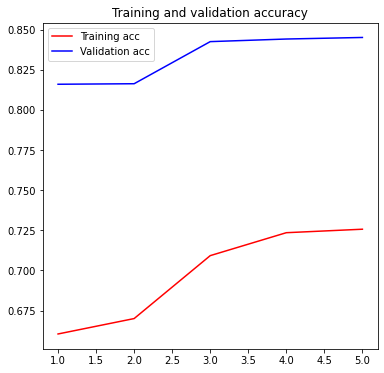

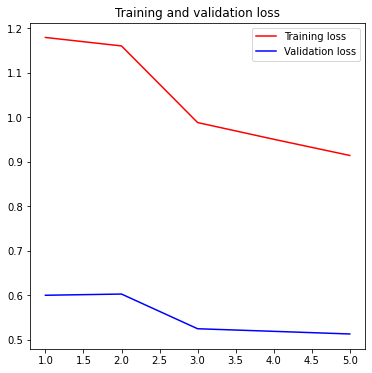

In [95]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [96]:
print(max(val_acc))

0.8451570868492126


In [97]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    print(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])
        print(idx)

[[[-1.843908   -1.230392   -1.8044444 ]
  [-1.7582842  -1.1428571  -1.7870152 ]
  [-1.6897851  -1.0903361  -1.6998693 ]
  ...
  [-1.5699118  -0.91526604 -1.8044444 ]
  [-1.5527872  -0.897759   -1.8044444 ]
  [-1.5699118  -0.91526604 -1.8044444 ]]

 [[-1.8267832  -1.212885   -1.8044444 ]
  [-1.7582842  -1.1428571  -1.7870152 ]
  [-1.6897851  -1.0903361  -1.6998693 ]
  ...
  [-1.5527872  -0.897759   -1.7695861 ]
  [-1.5527872  -0.897759   -1.8044444 ]
  [-1.5527872  -0.897759   -1.8044444 ]]

 [[-1.8096584  -1.1953781  -1.8044444 ]
  [-1.7411594  -1.12535    -1.7695861 ]
  [-1.6726604  -1.0728291  -1.68244   ]
  ...
  [-1.5356624  -0.880252   -1.7521569 ]
  [-1.5356624  -0.880252   -1.7870152 ]
  [-1.5527872  -0.897759   -1.8044444 ]]

 ...

 [[-1.8096584  -1.12535    -1.5430065 ]
  [-1.9466565  -1.247899   -1.7172985 ]
  [-1.980906   -1.265406   -1.8044444 ]
  ...
  [-1.4157891  -0.792717   -1.6127234 ]
  [-1.4500387  -0.827731   -1.6475817 ]
  [-1.4500387  -0.827731   -1.6475817 ]]

 [

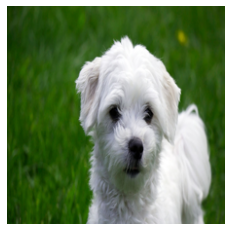

In [100]:
download_and_predict("https://images2.minutemediacdn.com/image/upload/c_fill,g_auto,h_1248,w_2220/v1555383129/shape/mentalfloss/istock_000040230564_small.jpg?itok=RuUesTL3",
                     "test_10.jpg")

[[[-0.06293353  0.3802522   0.8099348 ]
  [ 0.05693974  0.5903362   1.0539435 ]
  [ 0.60493195  1.2906163   1.8556864 ]
  ...
  [-0.04580877  0.3452382   0.9667976 ]
  [-0.08005828  0.3102242   0.9319392 ]
  [-0.11430778  0.2752102   0.8970808 ]]

 [[-0.04580877  0.3977592   0.827364  ]
  [ 0.05693974  0.57282925  1.0365143 ]
  [ 0.5878072   1.2731093   1.8382572 ]
  ...
  [-0.04580877  0.3452382   0.9667976 ]
  [-0.08005828  0.3102242   0.9319392 ]
  [-0.11430778  0.2752102   0.8970808 ]]

 [[-0.04580877  0.3977592   0.7925056 ]
  [ 0.03981499  0.55532223  1.0016559 ]
  [ 0.5535577   1.2380953   1.8033988 ]
  ...
  [-0.02868402  0.3627452   0.98422676]
  [-0.08005828  0.3102242   0.9319392 ]
  [-0.11430778  0.2752102   0.8970808 ]]

 ...

 [[-0.95342064 -0.35504198  0.2522005 ]
  [-0.9876702  -0.39005598  0.21734212]
  [-0.9705454  -0.40756297  0.21734212]
  ...
  [-0.81642264 -0.565126   -0.0092374 ]
  [-0.81642264 -0.565126   -0.0092374 ]
  [-0.8335474  -0.582633   -0.02666659]]

 [

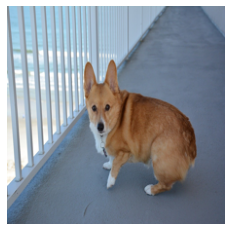

In [56]:
download_and_predict("https://cdn.pixabay.com/photo/2016/07/25/00/06/corgi-1539598_1280.jpg",
                     "test_2.jpg")

[[[-1.3815396 -1.265406  -0.9504139]
  [-1.3815396 -1.265406  -0.9504139]
  [-1.3815396 -1.265406  -0.9504139]
  ...
  [-1.2616663 -1.160364  -0.9329847]
  [-1.2616663 -1.160364  -0.9329847]
  [-1.2616663 -1.160364  -0.9329847]]

 [[-1.3815396 -1.265406  -0.9504139]
  [-1.3815396 -1.265406  -0.9504139]
  [-1.3815396 -1.265406  -0.9504139]
  ...
  [-1.2616663 -1.160364  -0.9329847]
  [-1.2616663 -1.160364  -0.9329847]
  [-1.2616663 -1.160364  -0.9329847]]

 [[-1.3815396 -1.265406  -0.9504139]
  [-1.3815396 -1.265406  -0.9504139]
  [-1.3815396 -1.265406  -0.9504139]
  ...
  [-1.2787911 -1.177871  -0.9504139]
  [-1.2787911 -1.177871  -0.9504139]
  [-1.2787911 -1.177871  -0.9504139]]

 ...

 [[-1.4671633 -1.352941  -1.0375599]
  [-1.4842881 -1.370448  -1.0549891]
  [-1.4842881 -1.370448  -1.0549891]
  ...
  [-1.4842881 -1.405462  -1.0724182]
  [-1.4842881 -1.405462  -1.0724182]
  [-1.4671633 -1.3879551 -1.0549891]]

 [[-1.4671633 -1.352941  -1.0375599]
  [-1.4842881 -1.370448  -1.0549891]


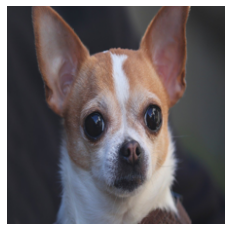

In [57]:
download_and_predict("https://cdn.pixabay.com/photo/2019/02/24/20/15/chihuahua-4018429_1280.jpg",
                     "test_3.jpg")

[[[-1.7240347 -1.6680672 -1.4210021]
  [-1.7240347 -1.6680672 -1.4210021]
  [-1.7240347 -1.6680672 -1.4210021]
  ...
  [-1.8610327 -1.8081232 -1.5604358]
  [-1.8610327 -1.8081232 -1.5604358]
  [-1.8610327 -1.8081232 -1.5604358]]

 [[-1.7240347 -1.6680672 -1.4210021]
  [-1.7240347 -1.6680672 -1.4210021]
  [-1.7240347 -1.6680672 -1.4210021]
  ...
  [-1.8610327 -1.8081232 -1.5604358]
  [-1.8610327 -1.8081232 -1.5604358]
  [-1.8610327 -1.8081232 -1.5604358]]

 [[-1.7240347 -1.6680672 -1.4210021]
  [-1.7240347 -1.6680672 -1.4210021]
  [-1.7240347 -1.6680672 -1.4210021]
  ...
  [-1.8610327 -1.8081232 -1.5604358]
  [-1.8610327 -1.8081232 -1.5604358]
  [-1.8610327 -1.8081232 -1.5604358]]

 ...

 [[-1.6041614 -1.5455182 -1.2989979]
  [-1.6041614 -1.5455182 -1.2989979]
  [-1.6041614 -1.5455182 -1.2989979]
  ...
  [-1.7240347 -1.6680672 -1.4210021]
  [-1.7240347 -1.6680672 -1.4210021]
  [-1.7240347 -1.6680672 -1.4210021]]

 [[-1.6041614 -1.5455182 -1.2989979]
  [-1.6041614 -1.5455182 -1.2989979]


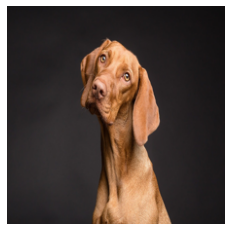

In [71]:
download_and_predict("https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
                     "test_4.jpg")

[[3.01469322e-06 2.55973021e-12 7.48083033e-14 1.24174782e-10
  4.37325550e-13 5.24650852e-12 8.60337079e-11 9.49355695e-07
  1.10593064e-05 2.55415120e-08 2.96600389e-09 1.40272294e-09
  5.47661791e-08 3.65984215e-10 3.22112070e-09 7.18075599e-10
  1.18393872e-08 6.54439145e-06 1.52512420e-08 1.83125707e-07
  1.44889975e-06 3.88317276e-05 1.94173435e-06 2.70588680e-06
  1.16840690e-10 4.56258249e-06 8.95323460e-09 2.05204499e-11
  1.22784002e-07 3.17588842e-07 1.06380538e-11 2.98596569e-06
  1.03609524e-10 7.93682193e-06 2.18007745e-08 2.30405749e-06
  7.29836590e-12 1.44036889e-08 7.44025197e-09 4.69436339e-12
  5.22857739e-08 9.99694976e-08 3.78171217e-10 1.69941006e-09
  9.13704112e-11 2.08102935e-09 2.03500810e-11 1.35076972e-09
  4.18292734e-09 3.37481940e-15 1.52124043e-11 6.55689725e-10
  8.64999652e-12 1.30039881e-12 3.54713953e-10 1.07197914e-11
  2.83679178e-08 6.35429700e-08 7.78401841e-07 9.55282589e-11
  1.33380151e-08 1.59237432e-11 4.02144629e-09 7.78593596e-12
  6.7717

(-0.5, 223.5, 223.5, -0.5)

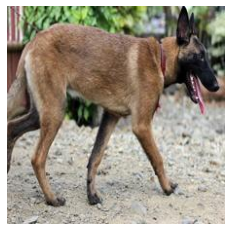

In [68]:
from tensorflow.keras.preprocessing import image
path = 'E:/Projects/tensorflow/breed_dog_only/notebook/test_1.jpg'
img = image.load_img(path, target_size=(224, 224))
x = image.img_to_array(img)
# print(x)
# print(x.ndim)
x = np.expand_dims(x, axis=0)
# print(x.ndim)
x = x/255.
classes = model.predict(x)
# print(fn)
print(classes)
print(classes[0][74])
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')

In [60]:
for idx in range(len(label_maps_rev)):
    print(label_maps_rev[idx].split("-")[-1])

Chihuahua
Japanese_spaniel
Maltese_dog
Pekinese
Tzu
Blenheim_spaniel
papillon
toy_terrier
Rhodesian_ridgeback
Afghan_hound
basset
beagle
bloodhound
bluetick
tan_coonhound
Walker_hound
English_foxhound
redbone
borzoi
Irish_wolfhound
Italian_greyhound
whippet
Ibizan_hound
Norwegian_elkhound
otterhound
Saluki
Scottish_deerhound
Weimaraner
Staffordshire_bullterrier
American_Staffordshire_terrier
Bedlington_terrier
Border_terrier
Kerry_blue_terrier
Irish_terrier
Norfolk_terrier
Norwich_terrier
Yorkshire_terrier
haired_fox_terrier
Lakeland_terrier
Sealyham_terrier
Airedale
cairn
Australian_terrier
Dandie_Dinmont
Boston_bull
miniature_schnauzer
giant_schnauzer
standard_schnauzer
Scotch_terrier
Tibetan_terrier
silky_terrier
coated_wheaten_terrier
West_Highland_white_terrier
Lhasa
coated_retriever
coated_retriever
golden_retriever
Labrador_retriever
Chesapeake_Bay_retriever
haired_pointer
vizsla
English_setter
Irish_setter
Gordon_setter
Brittany_spaniel
clumber
English_springer
Welsh_springer_s

In [99]:
model.save("its_done")

INFO:tensorflow:Assets written to: its_done\assets


In [ ]:
model = tf.keras.models.load_model('C:/Users/dedsec995/Projects/tensorflow/breed_dog_only/model/DOG/my_model')

In [92]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)